RAG is an AI framework for retrieving facts from an external knowledge base to ground large language models (LLMs) on the most accurate, up-to-date information and to give users insight into LLMs' generative process. Source: [What is retrieval-augmented generation?](https://research.ibm.com/blog/retrieval-augmented-generation-RAG)

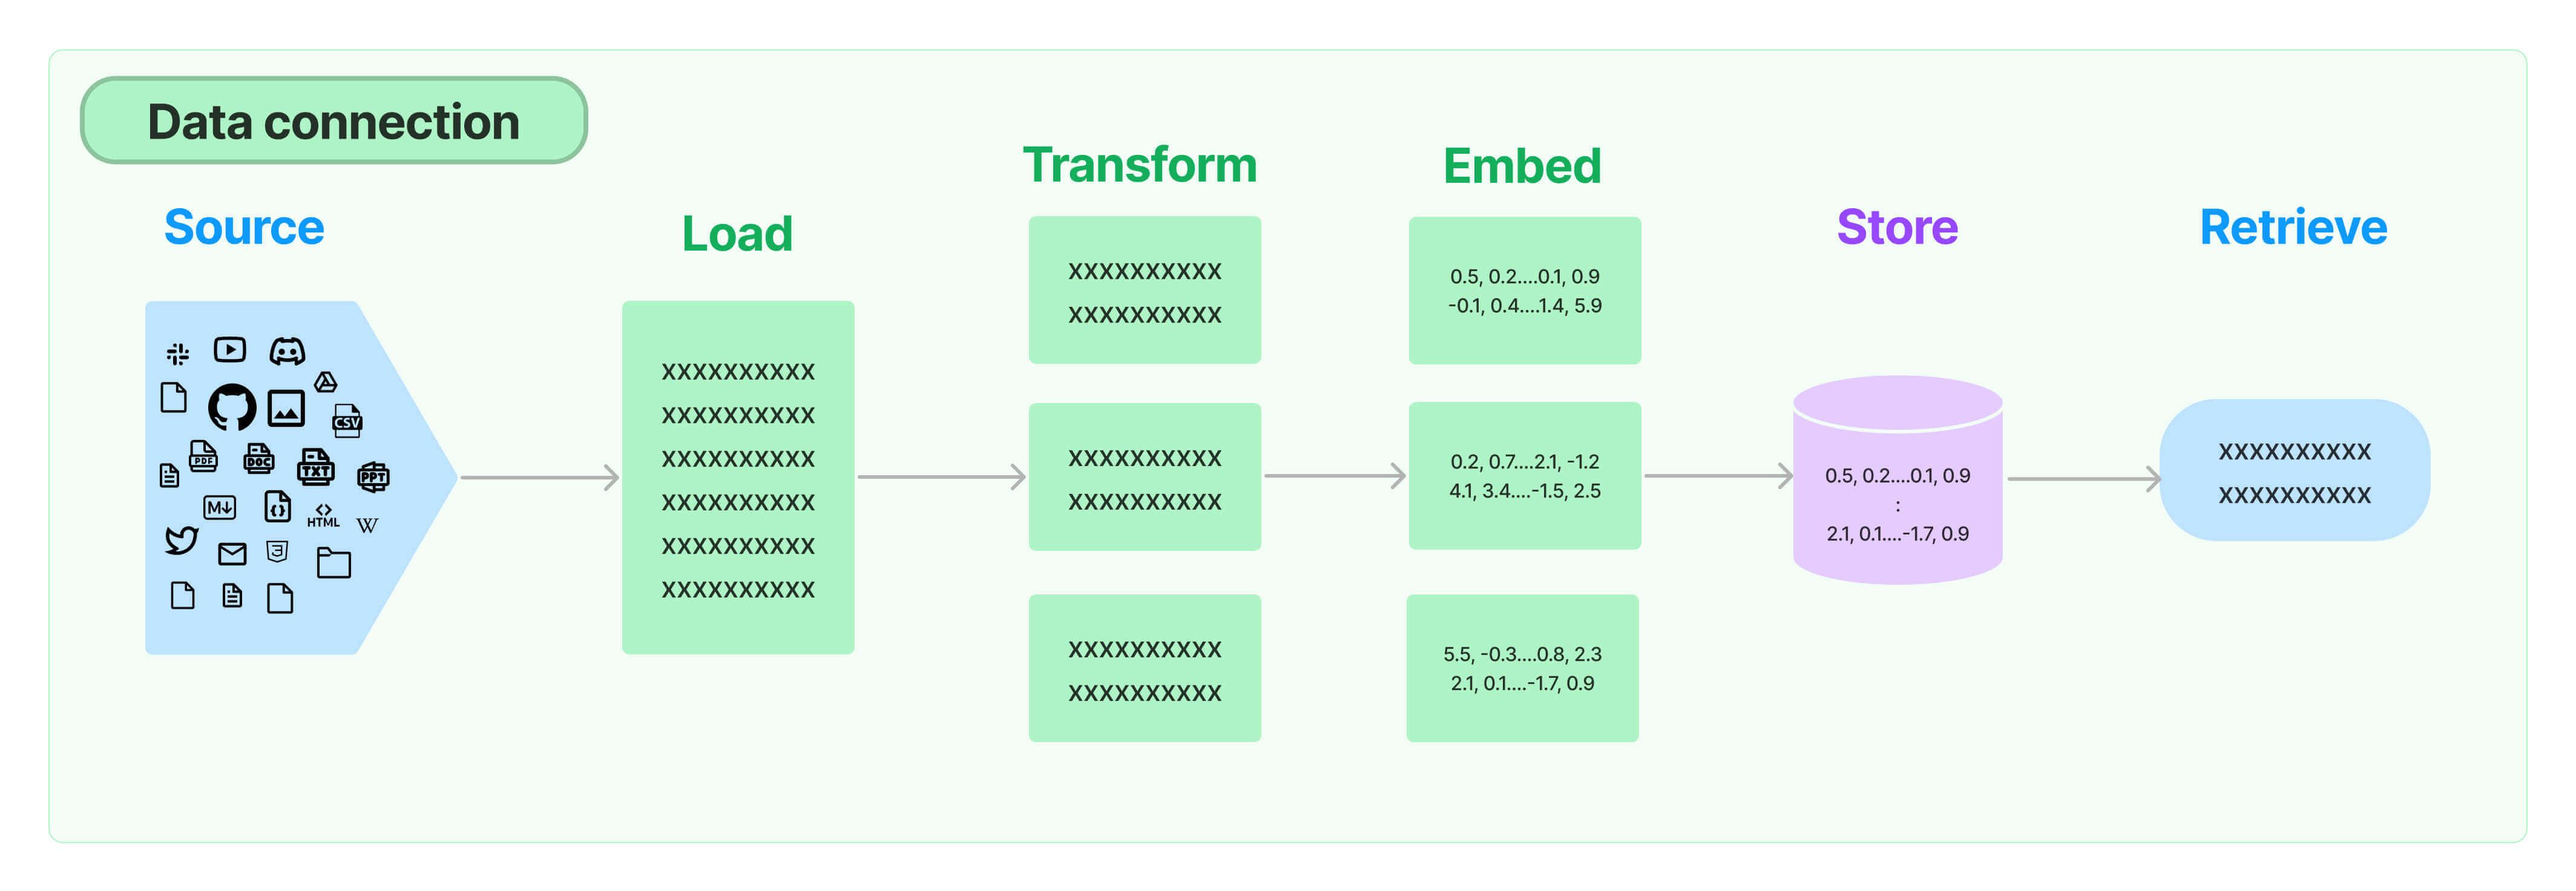

Source: [Langchain as an interface toolbox](https://python.langchain.com/docs/tutorials/rag/)


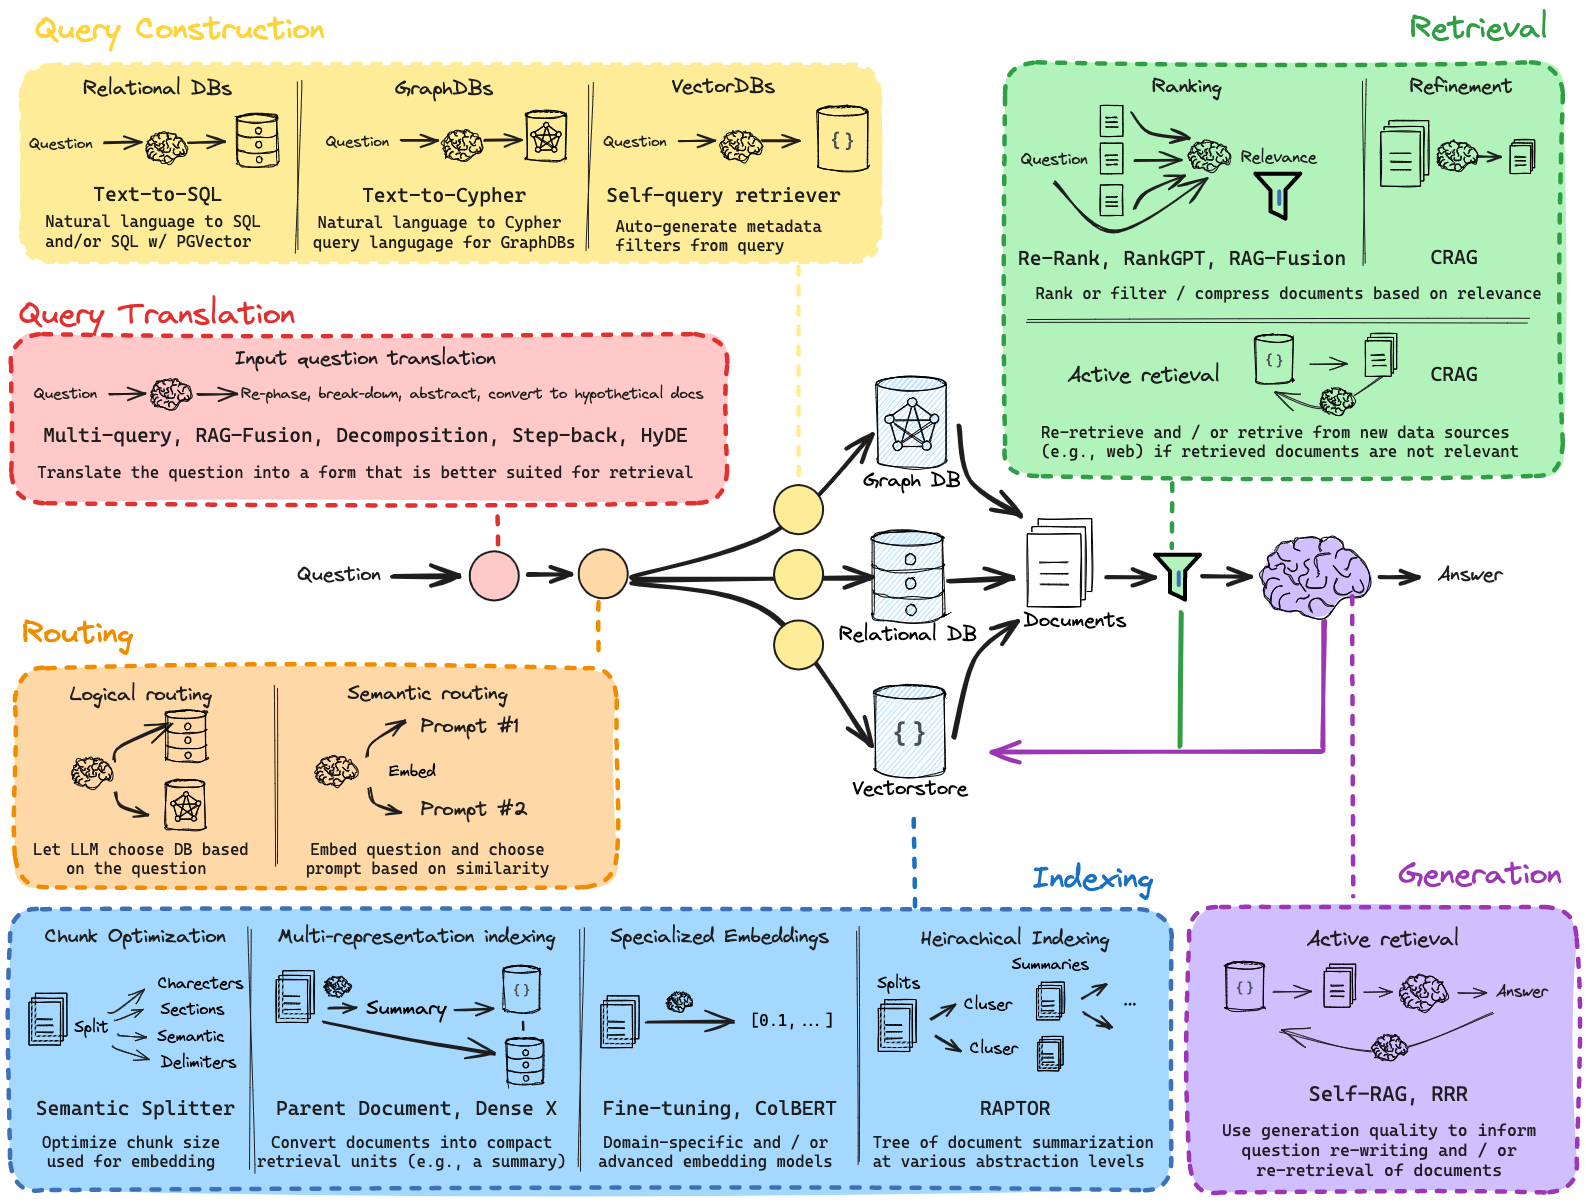

[Source: RAG conceptual guide](https://python.langchain.com/docs/concepts/#retrieval)

[RAG on MS Azure](https://learn.microsoft.com/en-us/azure/search/retrieval-augmented-generation-overview)

Demonstration

In [ ]:
!pip install --upgrade --quiet  langchain langchain-openai faiss-cpu tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 732.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.4/404.4 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.7/383.7 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.2/325.2 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.

In [ ]:
!pip install langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.3 MB/s eta 0:00:00


In [ ]:
from operator import itemgetter

from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

In [ ]:
import os
import openai
os.environ["OPENAI_API_KEY"] = "sk-proj-MLEybJFAMNvXCzYw95mJT3BlbkFJz9e3O8NhaQ6bx6t1zD4U"
openai.api_key = os.environ["OPENAI_API_KEY"]

In [ ]:
vectorstore = FAISS.from_texts(
    ["harrison worked at kensho"], embedding=OpenAIEmbeddings()
)
retriever = vectorstore.as_retriever()

template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

model = ChatOpenAI()

In [ ]:
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [ ]:
chain.invoke("where did harrison work?")

'Harrison worked at Kensho.'

In [ ]:
template = """Answer the question based only on the following context:
{context}

Question: {question}

Answer in the following language: {language}
"""
prompt = ChatPromptTemplate.from_template(template)

chain = (
    {
        "context": itemgetter("question") | retriever,
        "question": itemgetter("question"),
        "language": itemgetter("language"),
    }
    | prompt
    | model
    | StrOutputParser()
)

In [ ]:
chain.invoke({"question": "where did harrison work", "language": "italian"})

'Harrison ha lavorato a Kensho.'

Conversational Retrieval Chain
We can easily add in conversation history. This primarily means adding in chat_message_history

In [ ]:
from langchain_core.messages import AIMessage, HumanMessage, get_buffer_string
from langchain_core.prompts import format_document
from langchain_core.runnables import RunnableParallel

In [ ]:
from langchain.prompts.prompt import PromptTemplate

_template = """Given the following conversation and a follow up question, rephrase the follow up question to be a standalone question, in its original language.

Chat History:
{chat_history}
Follow Up Input: {question}
Standalone question:"""
CONDENSE_QUESTION_PROMPT = PromptTemplate.from_template(_template)

In [ ]:
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
ANSWER_PROMPT = ChatPromptTemplate.from_template(template)

In [ ]:
DEFAULT_DOCUMENT_PROMPT = PromptTemplate.from_template(template="{page_content}")


def _combine_documents(
    docs, document_prompt=DEFAULT_DOCUMENT_PROMPT, document_separator="\n\n"
):
    doc_strings = [format_document(doc, document_prompt) for doc in docs]
    return document_separator.join(doc_strings)

In [ ]:
_inputs = RunnableParallel(
    standalone_question=RunnablePassthrough.assign(
        chat_history=lambda x: get_buffer_string(x["chat_history"])
    )
    | CONDENSE_QUESTION_PROMPT
    | ChatOpenAI(temperature=0)
    | StrOutputParser(),
)
_context = {
    "context": itemgetter("standalone_question") | retriever | _combine_documents,
    "question": lambda x: x["standalone_question"],
}
conversational_qa_chain = _inputs | _context | ANSWER_PROMPT | ChatOpenAI()

In [ ]:
conversational_qa_chain.invoke(
    {
        "question": "where did harrison work?",
        "chat_history": [],
    }
)

AIMessage(content='Harrison worked at Kensho.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 7, 'prompt_tokens': 32, 'total_tokens': 39, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-e45b6ae2-df11-483e-a5d1-b23a479d5e1e-0', usage_metadata={'input_tokens': 32, 'output_tokens': 7, 'total_tokens': 39, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})

In [ ]:
conversational_qa_chain.invoke(
    {
        "question": "where did he work?",
        "chat_history": [
            HumanMessage(content="Who wrote this notebook?"),
            AIMessage(content="Harrison"),
        ],
    }
)

AIMessage(content='Harrison worked at Kensho.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 7, 'prompt_tokens': 32, 'total_tokens': 39, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-c2554b37-9c2e-402e-9d96-0d946edab93e-0', usage_metadata={'input_tokens': 32, 'output_tokens': 7, 'total_tokens': 39, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})

With Memory and returning source documents
This shows how to use memory with the above. For memory, we need to manage that outside at the memory. For returning the retrieved documents, we just need to pass them through all the way.

In [ ]:
from operator import itemgetter

from langchain.memory import ConversationBufferMemory

In [ ]:
memory = ConversationBufferMemory(
    return_messages=True, output_key="answer", input_key="question"
)

<ipython-input-18-bae6e4ea687a>:1: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(


In [ ]:
# First we add a step to load memory
# This adds a "memory" key to the input object
loaded_memory = RunnablePassthrough.assign(
    chat_history=RunnableLambda(memory.load_memory_variables) | itemgetter("history"),
)
# Now we calculate the standalone question
standalone_question = {
    "standalone_question": {
        "question": lambda x: x["question"],
        "chat_history": lambda x: get_buffer_string(x["chat_history"]),
    }
    | CONDENSE_QUESTION_PROMPT
    | ChatOpenAI(temperature=0)
    | StrOutputParser(),
}
# Now we retrieve the documents
retrieved_documents = {
    "docs": itemgetter("standalone_question") | retriever,
    "question": lambda x: x["standalone_question"],
}
# Now we construct the inputs for the final prompt
final_inputs = {
    "context": lambda x: _combine_documents(x["docs"]),
    "question": itemgetter("question"),
}
# And finally, we do the part that returns the answers
answer = {
    "answer": final_inputs | ANSWER_PROMPT | ChatOpenAI(),
    "docs": itemgetter("docs"),
}
# And now we put it all together!
final_chain = loaded_memory | standalone_question | retrieved_documents | answer

In [ ]:
inputs = {"question": "where did harrison work?"}
result = final_chain.invoke(inputs)
result

{'answer': AIMessage(content='Harrison worked at Kensho.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 7, 'prompt_tokens': 32, 'total_tokens': 39, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-3683ee65-d1dd-43c3-aeea-549f968033f4-0', usage_metadata={'input_tokens': 32, 'output_tokens': 7, 'total_tokens': 39, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}}),
 'docs': [Document(metadata={}, page_content='harrison worked at kensho')]}

In [ ]:
# Note that the memory does not save automatically
# This will be improved in the future
# For now you need to save it yourself
memory.save_context(inputs, {"answer": result["answer"].content})

In [ ]:
memory.load_memory_variables({})

{'history': [HumanMessage(content='where did harrison work?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Harrison worked at Kensho.', additional_kwargs={}, response_metadata={})]}

In [ ]:
inputs = {"question": "but where did he really work?"}
result = final_chain.invoke(inputs)
result

{'answer': AIMessage(content='Harrison really worked at Kensho.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 33, 'total_tokens': 41, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-67de732f-1ae8-4e03-990f-ca094c9445fc-0', usage_metadata={'input_tokens': 33, 'output_tokens': 8, 'total_tokens': 41, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}}),
 'docs': [Document(metadata={}, page_content='harrison worked at kensho')]}